# Pricing with Rational Inattnetion: Sims (2011)

This notebook replicates [Sims (2011)](http://sims.princeton.edu/yftp/RIMP/handbookChapterRI2.pdf) from the Handbook of Monetary Economics using the methods and the [solver](https://github.com/choongryulyang/dynamic_multivariate_RI) from [Afrouzi and Yang (2019)](http://www.afrouzi.com/dynamic_inattention.pdf) that was adapted for Julia by [Miguel Acosta](https://www.acostamiguel.com/home). 

## Contents
* [Setup](#setup)
* [Initialization](#param)
* [Solution](#solution)
    * [Benchmark Parameterization](#benchmark)
    * [Lower Cost of Attention: $\omega = 0.1$](#lowomega)
    * [Other Discount Factors: $\beta \in \{0,1\}$](#betas)
* [Impulse Response Functions](#figures)
    * [Benchmark Parameterization](#fig_benchmark)
    * [Lower Cost of Attention: $\omega = 0.1$](#fig_lowomega)
    * [Other Discount Factors: $\beta \in \{0,1\}$](#fig_betas)
* [Extensions](#extensions) 
    * [Transition Dynamics of Attention](#trip)
    * [Impulse Response Functions with Information Treatment](#trip_irfs)

## Setup <a class="anchor" id="setup"></a>

The problem in [Sims (2011)](http://sims.princeton.edu/yftp/RIMP/handbookChapterRI2.pdf), as it appears on page 21, with slight change of notation, 
\begin{align}
	          & \min_{\{\Sigma_{t|t}\succeq 0\}} \mathbb{E}_0\left[\sum_{t=0}^\infty\
	\beta^t \left(tr(\Sigma_{t|t}\mathbf{H}\mathbf{H}')+\omega\log\left(\frac{|\Sigma_{t|t-1}|}{|\Sigma_{t|t}|}\right)\right)\right] \\
	s.t.\quad &
	\Sigma_{t+1|t}=\mathbf{A}\Sigma_{t|t}\mathbf{A}'+\mathbf{Q}\mathbf{Q}'\\
	          & \Sigma_{t|t-1}-\Sigma_{t|t} \text{ positive semi-definite}
\end{align}

where 
\begin{align}
	\mathbf{H} = \left[\begin{array}{c} 1 \\ 1\end{array}\right],
    \quad
    \mathbf{A} = \left[\begin{array}{cc}
							0.95 & 0\\
							0 & 0.4\\
					   \end{array}\right],
	\quad
	\mathbf{Q} = \left[\begin{array}{cc}
							\sqrt{0.0975} & 0\\
							0 			& \sqrt{0.86}\\
					   \end{array}\right] 
\end{align}
We have renamed the parameters so that the problem directly maps to a D.R.I.P. Otherwise, the problem is the same.

## Initialization <a class="anchor" id="param"></a>
Include the solver:

In [1]:
include("DRIP.jl");

Import supporting packages and aux. commands:

In [2]:
using Printf, Plots, LaTeXStrings, BenchmarkTools; pyplot();
Base.show(io::IO, f::Float64) = @printf io "%1.3f" f #rounds up floats for display

Set parameters:

In [3]:
## Primitives of D.R.I.P.
β = 0.9;
ω = 1.0;
A = [0.95 0.0; 0.0 0.4];
Q = [√0.0975 0.0; 0.0 √0.86];
H = [1.0; 1.0];

## Solution and Performance<a class="anchor" id="solution"></a>
### Benchmark Parameterization <a class="anchor" id="benchmark"></a>
Solve and display the optimal posterior covariance matrix:

In [4]:
sol_bp = solve_drip(ω,β,A,Q,H);
display(sol_bp.Σ_p)

2×2 Array{Float64,2}:
  0.359  -0.177
 -0.177   0.795

Performance for random values of $\omega\in [0,2]$:

In [5]:
@benchmark solve_drip(ω,β,A,Q,H) setup = (ω = 2*rand())

BenchmarkTools.Trial: 
  memory estimate:  363.28 KiB
  allocs estimate:  2145
  --------------
  minimum time:     269.828 μs (0.00% GC)
  median time:      427.627 μs (0.00% GC)
  mean time:        482.297 μs (10.37% GC)
  maximum time:     8.532 ms (93.33% GC)
  --------------
  samples:          10000
  evals/sample:     1

Performance for random values of $\beta\in[0,1]$:

In [6]:
@benchmark solve_drip(ω,β,A,Q,H) setup = (β = rand()) 

BenchmarkTools.Trial: 
  memory estimate:  366.36 KiB
  allocs estimate:  2152
  --------------
  minimum time:     317.774 μs (0.00% GC)
  median time:      480.493 μs (0.00% GC)
  mean time:        539.690 μs (9.93% GC)
  maximum time:     8.687 ms (94.01% GC)
  --------------
  samples:          9222
  evals/sample:     1

### Lower Cost of Attention: $\omega = 0.1$ <a class="anchor" id="lowomega"></a>
Solve and display the optimal posterior covariance matrix:

In [7]:
sol_lω = solve_drip(0.1,β,A,Q,H);
display(sol_lω.Σ_p)

2×2 Array{Float64,2}:
  0.320  -0.304
 -0.304   0.386

### Different Discount Factors: $\beta \in \{0,1\}$ <a class="anchor" id="betas"></a>
Solve the model for $\beta=0$ and $\beta=1$ to compare with the benchmark value of $\beta=0.9$:

In [8]:
sol_lβ = solve_drip(ω,0,A,Q,H); display(sol_lβ.Σ_p);

2×2 Array{Float64,2}:
  0.495  -0.152
 -0.152   0.809

In [9]:
sol_hβ = solve_drip(ω,1,A,Q,H); display(sol_hβ.Σ_p);

2×2 Array{Float64,2}:
  0.338  -0.178
 -0.178   0.800

## Impulse Response Functions <a class="anchor" id="figures"></a>
### Benchmark Parameterization <a class="anchor" id="fig_benchmark"></a>
Get the IRFs:

In [10]:
T = 25; #length of IRFs
irfs_bp = dripirfs(sol_bp,T);

Plot IRFs:

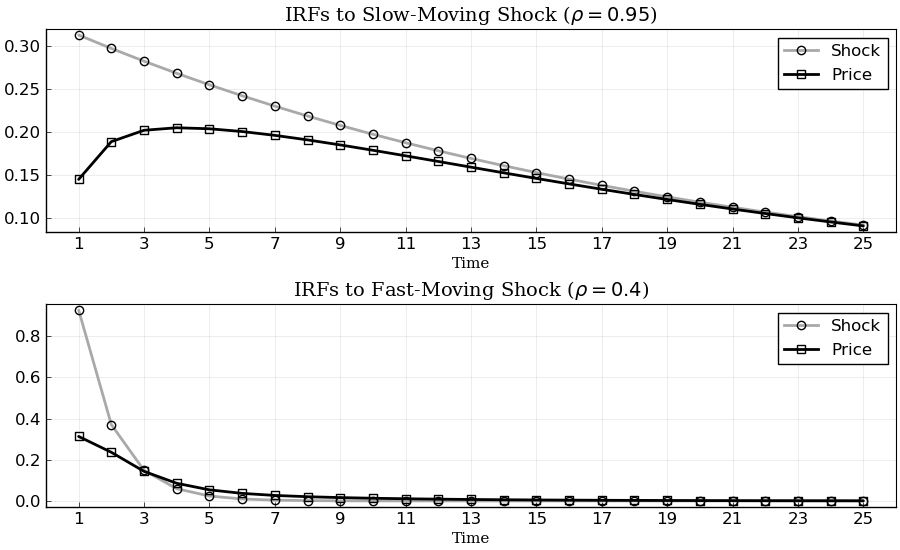

In [11]:
p1 = plot(1:T, [irfs_bp.x[1,1,:], irfs_bp.a[1,1,:]],
    title             = L"IRFs to Slow-Moving Shock ($\rho = 0.95$)",
    label             = ["Shock" "Price"],
    color             = [:darkgray :black],
    marker            = [:circle :square],
    markerstrokecolor = :match,
    markercolor       = false,
    markersize        = 6)
p2 = plot(1:T, [irfs_bp.x[2,2,:], irfs_bp.a[1,2,:]],
    title             = L"IRFs to Fast-Moving Shock ($\rho = 0.4$)",
    label             = ["Shock" "Price"],
    color             = [:darkgray :black],
    marker            = [:circle :square],
    markerstrokecolor = :match,
    markercolor       = false,
    markersize        = 6)
p = plot(p1,p2,
    layout     = (2,1),
    xlabel     = "Time",
    lw         = 2,
    xticks     = (1:2:T),
    xlim       = (0,T+1),
    fontfamily = "serif",
    legend     = :topright,
    legendfont = font(12),
    tickfont   = font(12),
    size       = (900,550),
    framestyle = :box)

### Lower Cost of Attention: $\omega=0.1$ <a class="anchor" id="fig_lowomega"></a>
Get the IRFs:

In [12]:
T = 25; #length of IRFs
irfs_lω = dripirfs(sol_lω,T);

Plot IRFs:

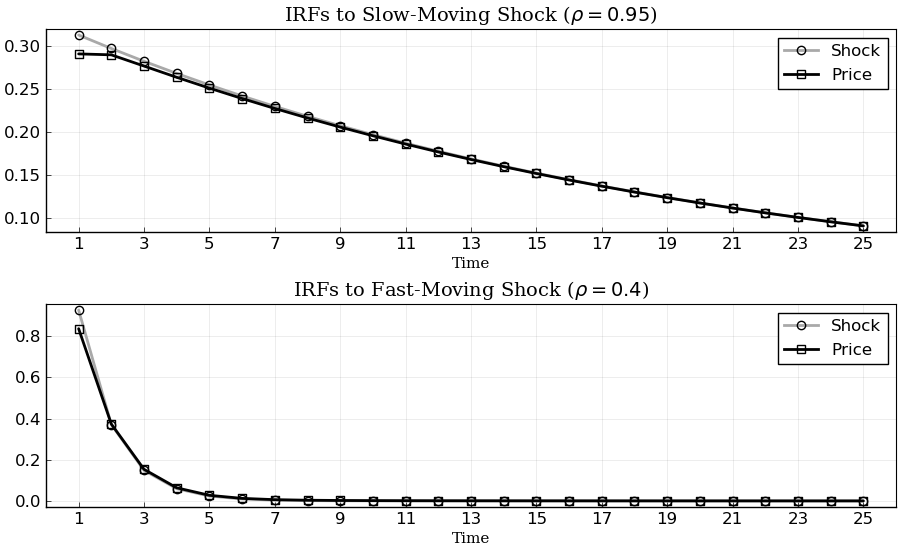

In [13]:
p1 = plot(1:T, [irfs_lω.x[1,1,:], irfs_lω.a[1,1,:]],
    title             = L"IRFs to Slow-Moving Shock ($\rho = 0.95$)",
    label             = ["Shock" "Price"],
    color             = [:darkgray :black],
    marker            = [:circle :square],
    markerstrokecolor = :match,
    markercolor       = false,
    markersize        = 6)
p2 = plot(1:T, [irfs_lω.x[2,2,:], irfs_lω.a[1,2,:]],
    title             = L"IRFs to Fast-Moving Shock ($\rho = 0.4$)",
    label             = ["Shock" "Price"],
    color             = [:darkgray :black],
    marker            = [:circle :square],
    markerstrokecolor = :match,
    markercolor       = false,
    markersize        = 6)
p = plot(p1,p2,
    layout     = (2,1),
    xlabel     = "Time",
    lw         = 2,
    xticks     = (1:2:T),
    xlim       = (0,T+1),
    fontfamily = "serif",
    legend     = :topright,
    legendfont = font(12),
    tickfont   = font(12),
    size       = (900,550),
    framestyle = :box)

### Other Discount Factors: $\beta\in\{0,1\}$ <a class="anchor" id="fig_betas"></a>
Get the IRFs:

In [14]:
T = 25; #length of IRFs
irfs_lβ = dripirfs(sol_lβ,T);
irfs_hβ = dripirfs(sol_hβ,T);

Plot IRFs:

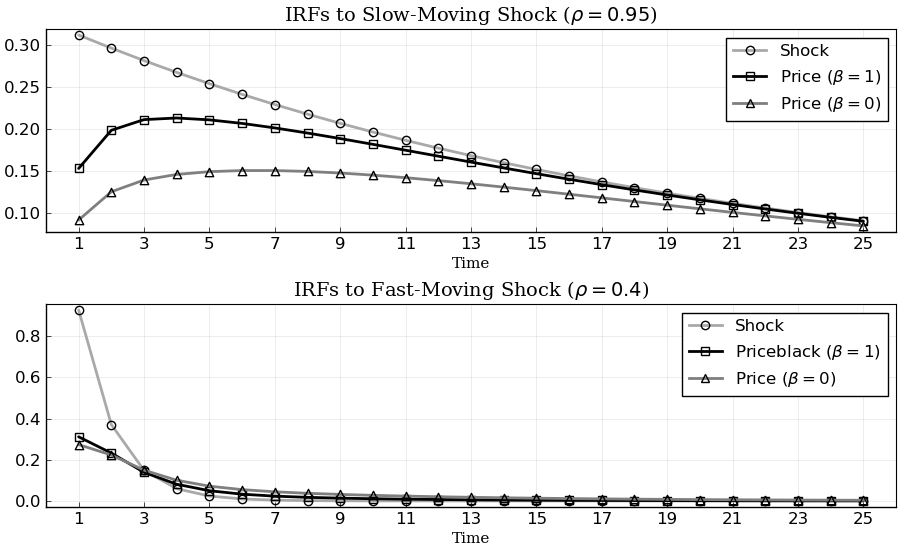

In [15]:
p1 = plot(1:T, [irfs_bp.x[1,1,:],irfs_hβ.a[1,1,:], irfs_lβ.a[1,1,:]],
    title             = L"IRFs to Slow-Moving Shock ($\rho = 0.95$)",
    label             = ["Shock" L"Price ($\beta=1$)" L"Price ($\beta=0$)"],
    color             = [:darkgray :black :gray50],
    marker            = [:circle :square :utriangle],
    markerstrokecolor = :match,
    markercolor       = false,
    markersize        = 6)
p2 = plot(1:T, [irfs_bp.x[2,2,:],irfs_hβ.a[1,2,:], irfs_lβ.a[1,2,:]],
    title             = L"IRFs to Fast-Moving Shock ($\rho = 0.4$)",
    label             = ["Shock" L"Priceblack ($\beta=1$)" L"Price ($\beta=0$)"],
    color             = [:darkgray :black :gray50],
    marker            = [:circle :square :utriangle],
    markerstrokecolor = :match,
    markercolor       = false,
    markersize        = 6)
p = plot(p1,p2,
    layout     = (2,1),
    xlabel     = "Time",
    lw         = 2,
    xticks     = (1:2:T),
    xlim       = (0,T+1),
    fontfamily = "serif",
    legend     = :topright,
    legendfont = font(12),
    tickfont   = font(12),
    size       = (900,550),
    framestyle = :box)

## Extensions <a class="anchor" id="extensions"></a>

### Transition Dynamics of Attention <a class="anchor" id="trip"></a>

In this section, we solve for the transition dynamics of the optimal posterior covariance matrix starting from an initial prior that is different from the steady state prior. 

For instance let us consider a case where the firm is at the steady state of the rational inattention problem at time 0, with prior covariance matrix $\bar{\Sigma}_{-1}$, and it receives a one time treatment with a perfectly informative signal about its optimal price:

$$s_0 = \mathbf{H}'\vec{x}_0$$

Then, the new prior covariance matrix is 

$$ \Sigma_0 = \bar{\Sigma}_{-1}-\frac{\bar{\Sigma}_{-1}\mathbf{H}\mathbf{H}'\bar{\Sigma}_{-1}}{\mathbf{H}'\bar{\Sigma}_{-1}\mathbf{H}} $$
Let's see how the initial prior is different from the steady state prior:

In [16]:
Σ_1     = sol_bp.Σ_1;                      # steady state prior
Σ0      = Σ_1 - (Σ_1*H*H'*Σ_1)/(H'*Σ_1*H); # prior after treatment
display(Σ_1); display(Σ0);                 # display prior before and after treatment

2×2 Array{Float64,2}:
  0.422  -0.067
 -0.067   0.987

2×2 Array{Float64,2}:
  0.323  -0.323
 -0.323   0.323

#### Solve for the transition dynamics
The function `solve_trip` solves for the transition dynamics automatically given the initial signal. Start by initializing the initial signal:

In [17]:
s0 = Signal(H,0.0);

Solve for the transition dynamics given $s_0$:

In [18]:
Tss     = 15; # guess for time until convergence
bp_trip = solve_trip(sol_bp, s0; T = Tss);

Performance for solving the transition dynamics for a random signal:

In [19]:
@benchmark solve_trip(sol_bp, S; T = 30) setup = (S = Signal(rand(2),0.0))

BenchmarkTools.Trial: 
  memory estimate:  837.84 KiB
  allocs estimate:  6256
  --------------
  minimum time:     951.164 μs (0.00% GC)
  median time:      1.232 ms (0.00% GC)
  mean time:        1.401 ms (9.80% GC)
  maximum time:     9.963 ms (85.15% GC)
  --------------
  samples:          3563
  evals/sample:     1

#### Plot Transition Path of Eigenvalues

Plot the marginal values of information. In this problem the state is two dimensional. At any time, for every orthogonalized dimension, the agent weighs the **marginal value** of acquiring information in that dimension against the **marginal cost** of attention which is the parameter $\omega$.**The number of signals that the agent acquires at any time is the number of marginal values that are larger than $\omega$.**

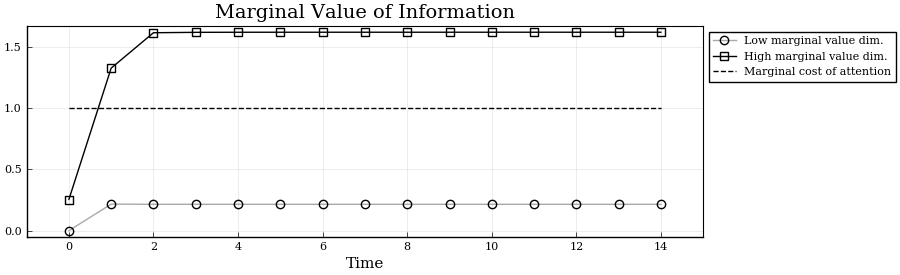

In [20]:
p = plot(0:Tss-1,[bp_trip.Ds[1,1:Tss],bp_trip.Ds[2,1:Tss],bp_trip.P.ω*ones(Tss,1)],
    label             = ["Low marginal value dim." "High marginal value dim." "Marginal cost of attention"],
    size              = (900,275),
    title             = "Marginal Value of Information",
    xlabel            = "Time",
    color             = [:darkgray :black :black],
    line              = [:solid :solid :dash],
    marker            = [:circle :square :none],
    markercolor       = false,
    markerstrokecolor = :match,
    markersize        = 6,
    xlim              = (-1,Tss),
    xticks            = 0:2:Tss-1,
    legend            = :outertopright,
    fontfamily        = "serif",
    framestyle        = :box)

### Impulse Response Functions with Information Treatment <a class="anchor" id="trip_irfs"></a>
Get the IRFs in the transition path after treatment:

In [21]:
T = 30; #length of IRFs

tirfs_bp = dripirfs(sol_bp,T,s0); # irfs with treatment
irfs_bp  = dripirfs(sol_bp,T);    # irfs in the Ss (without treatment)

Plot IRFs:

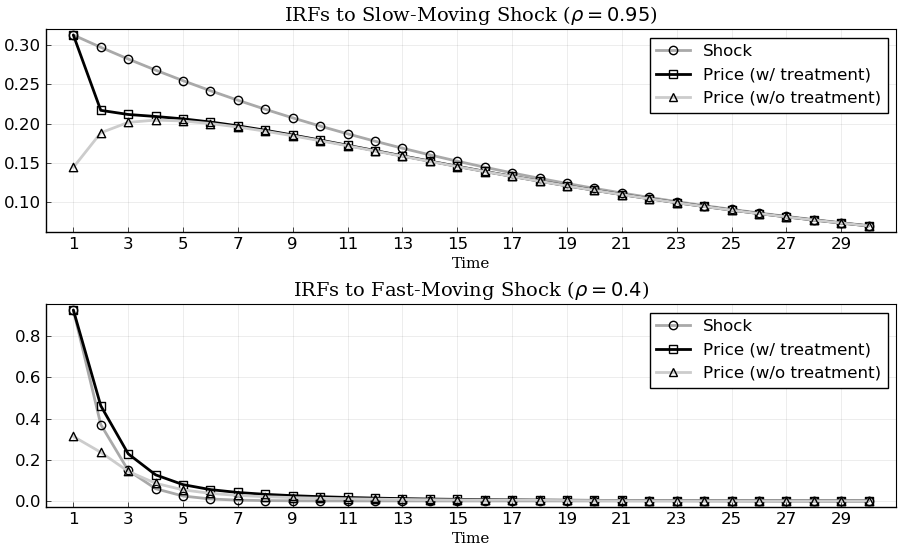

In [22]:
p1 = plot(1:T, [irfs_bp.x[1,1,:], tirfs_bp.a[1,1,:], irfs_bp.a[1,1,:]],
    title             = L"IRFs to Slow-Moving Shock ($\rho = 0.95$)",
    label             = ["Shock" "Price (w/ treatment)" "Price (w/o treatment)"],
    color             = [:darkgray :black :gray80],
    marker            = [:circle :square :utriangle],
    markerstrokecolor = :match,
    markercolor       = false,
    markersize        = 6)
p2 = plot(1:T, [tirfs_bp.x[2,2,:], tirfs_bp.a[1,2,:], irfs_bp.a[1,2,:]],
    title             = L"IRFs to Fast-Moving Shock ($\rho = 0.4$)",
    label             = ["Shock" "Price (w/ treatment)" "Price (w/o treatment)"],
    color             = [:darkgray :black :gray80],
    marker            = [:circle :square :utriangle],
    markerstrokecolor = :match,
    markercolor       = false,
    markersize        = 6)
p = plot(p1,p2,
    layout     = (2,1),
    xlabel     = "Time",
    lw         = 2,
    xticks     = (1:2:T),
    xlim       = (0,T+1),
    fontfamily = "serif",
    legend     = :topright,
    legendfont = font(12),
    tickfont   = font(12),
    size       = (900,550),
    framestyle = :box)